# 06. Surprise 패키지
- Python에서 CF와 MF기반 추천 시스템을 구현하고 테스트하는 패키지

```pytnon
pip install scikit-surprise
```

<br>

## 06.01. Surprise 기본
- 사용 가능한 알고리즘 (https://surpriselib.com/)

| | |
| - | - |
| `random_pred.NormalPredictor` | 훈련데이터이ㅡ 분포가 정규분포라고 가정한 상태에서 평점을 무작위로 추출하는 알고리즘. 일반적으로 성능이 안좋음|
| `baseline_only.BaselineOnly`| 사용자의 평점평균과 아이템의 평점평균을 모델화해서 에측하는 알고리즘 |
| `knns.KNNBasic` | 이웃을 고려한 기본적인 CF알고리즘|
| `knns.KNNWithMeans`| 사용자의 평가경향을 고려한 CF알고리즘 |
| `knns.KNNWithZScore`| 사용자의 평가경향을 표준(정규분포)화시킨 CF알고리즘|
| `knns.KNNBaseline`| 사용자의 평점평균과 아이템의 평점평균을 모델화시킨 것(Baseline rating)을 고려한 CF알고리즘|
| `matrix_factorization.SVD` |MF알고리즘|
|`matrix_factorization.SVDpp`| MF를 기반으로 사용자의 특정 아이템에 대한 평가여부를 이진값으로 일종의 암묵적 평가(implicit ratings)로 추가한 SVD++ 알고리즘 |
| `matrix_factorization.NMF` | 행렬의 값이 전부 양수일 떄 사용 가능한 MF 알고리즘 |
| `slope_one.SlopeOne` | 간단하면서도 정확도가 높은 것이 특징인 SlopeOne 알고리즘을 적용한, 아이템기반 CF알고리즘|
| `co_clustering.CoClustering` | 사용자와 아이템을 동시에 클러스터링하는 기법을 적용한 CF 알고리즘 |

<br>

In [2]:
import numpy as np
import pandas as pd

- 알고리즘 로드

In [3]:
from surprise import BaselineOnly
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

- MovieLens 100K 데이터 로드

In [4]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.25)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [5]:
algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9597


0.959664267222838

<br>

## 06.02. 알고리즘 비교
- `Surprise`에서 지원하는 알고리즘 중 `BaselinOnly`, `KNNWithMeans`, `SVD`, `SVDpp`에 대한 비교

In [6]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.25)

- 알고리즘 비교

In [7]:
algorithms = [BaselineOnly, KNNWithMeans, SVD, SVDpp]

In [8]:
names = []
results = []
for option in algorithms:
    algo = option()
    names.append(option.__name__)
    algo.fit(trainset)
    predictions = algo.test(testset)
    results.append(accuracy.rmse(predictions))

names = np.array(names)
results = np.array(results)

Estimating biases using als...
RMSE: 0.9439
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9521
RMSE: 0.9385
RMSE: 0.9184


In [9]:
import matplotlib.pyplot as plt

array([0.91843702, 0.93848238, 0.94388272, 0.95206283])

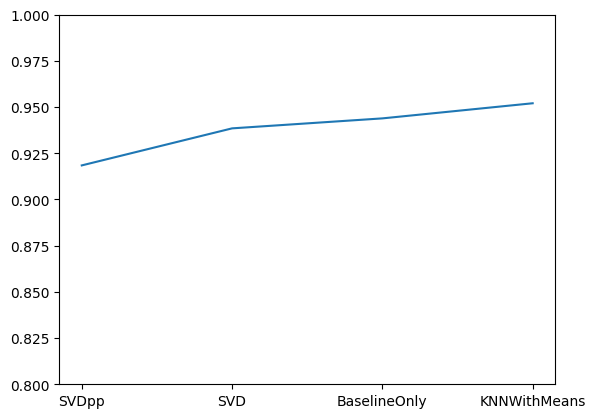

In [10]:
index = np.argsort(results)
plt.ylim(0.8, 1)
plt.plot(names[index], results[index])
results[index]
plt.show()

<br>

## 06.03. 알고리즘 파라미터 변경
- `Surprise`에서 KNN CF를 실행시 기본 $K$는 40, 유사도지표의 기본값은 MSD (Mean Squared Deviation = Mean Square Error)

In [11]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.25)

- 알고리즘 파리미터 변경
  - 공식 문서 참조 [https://surprise.readthedocs.io/en/stable/index.html]
  - `KNNWithMeans`의 경우, `name`에는 유사도지표의 종류를 지정 (`cosine`, `msd`, `pearson`, `pearson_baseline`)
  - `user_based`가 `True`일 시, User-Based CF (UBCF) 알고리즘을 사용

    `False`일 시, Item-Based CF (IBCF) 알고리즘을 사용

In [12]:
sim_options = {'name': 'pearson_baseline',  'user_based': True}

In [13]:
algo = KNNWithMeans(k=30, sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9401


0.9400726527106849

<br>

## 06.04. 다양한 조건의 비교
- Neighbor Size $K$에 대한 파라미터 튜닝

In [14]:
result = []
for neighbor_size in (10, 20, 30, 40, 50, 60):
    algo = KNNWithMeans(k=neighbor_size,
                        sim_options={'name': 'pearson_baseline', 'user_based': True})
    algo.fit(trainset)
    predictions = algo.test(testset)
    result.append([neighbor_size, accuracy.rmse(predictions)])

result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9542
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9421
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9401
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9400
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9399
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9401


[[10, 0.9542373283626825],
 [20, 0.9420712062160063],
 [30, 0.9400726527106849],
 [40, 0.9399752457157684],
 [50, 0.9398561462157604],
 [60, 0.9400629414295968]]

- $K=40$일 때, 가장 낮은 RMSE값을 가짐

In [25]:
np.argmin(np.array(result)[:, 1])

4

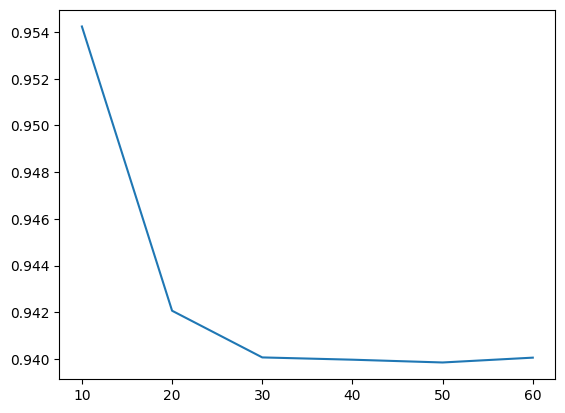

In [23]:
plt.plot(np.array(result)[:, 0], np.array(result)[:, 1])
plt.show()

<br>

### 그리드서치

<br>

#### KNN의 파리미터에 대한 그리드 서치

In [34]:
from surprise.model_selection import GridSearchCV

In [35]:
param_grid = {'k': [5, 10, 15, 25], # KNN 이웃의 크기
              'sim_options': {'name': ['pearson_baseline', 'cosine'], # 유사도 지표
                              'user_based': [True, False]} # UBCF / IBCF 여부
              }

In [36]:
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=4, joblib_verbose=False)
gs.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similar

In [37]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9252816463693522
{'k': 25, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}


<br>

#### SVD의 파리미터에 대한 그리드 서치

In [38]:
param_grid = {'n_epochs': [70, 80, 90], # 반복횟수
              'lr_all': [0.005, 0.006, 0.007], # 학습률 alpha
              'reg_all': [0.05, 0.07, 0.1]} # 정규화 계수 beta

In [39]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=4, joblib_verbose=False)
gs.fit(data)

In [40]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9120682599936046
{'n_epochs': 90, 'lr_all': 0.005, 'reg_all': 0.1}


<br>

## 06.05. 외부 데이터 사용
- csv 파일 읽기

```python
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', names=r_cols,  sep='\t',encoding='latin-1')
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
```